## NLP solver reference
- sciPy
    - https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html#constrained-minimization-of-multivariate-scalar-functions-minimize
    - https://docs.scipy.org/doc/scipy/reference/optimize.html

In [1]:
from scipy.optimize import minimize
from scipy.optimize import Bounds

import matplotlib.pyplot as plt
import numpy as np
import time

state 및 control을 N개의 piece-wise로 쪼갠다고 가정.
$$
x[0] : t_{f} \\
x[1:N+2] : u_0, u_1, ..., u_N \\
x[N+2:3*N+4] : x_0, \dot{x}_0, x_1, \dot{x}_1, ..., x_N, \dot{x}_N \\
$$

In [3]:
def dynamics(x, u):
    A_mat = np.array([[0, 1], [0, 0]])
    B_mat = np.array([[0], [1]])
    result = np.matmul(A_mat, x) + np.matmul(B_mat, u)
    return result

In [4]:
def obj_func(x):
    f = x[0]
    return f

def obj_jacobian(x):
    jacobian = np.zeros((1, len(x)))
    jacobian[0, 0] = 1.0
    return jacobian

In [17]:
def ineq_cons_func(x):
    N = int((len(x) - 1)/3 - 1)
    t_f = x[0]
    u_list = np.array(x[1:N+2]).reshape((N+1, 1))
    x_list = np.array(x[N+2:]).reshape((N+1, 2))
    dt = t_f/N
    
    # get x_dot from dynamics
    x_dot_list = dynamics(x_list.T, u_list.T).T
    
    # transform variables for pice-wise polynomial
    x_left = x_list[:N,:]
    x_right = x_list[1:,:]
    x_dot_left = x_dot_list[:N,:]
    x_dot_right = x_dot_list[1:,:]
    u_left = u_list[:N,:]
    u_right = u_list[1:,:]
    
    # get collocation points
    x_c = 0.5*(x_left + x_right) + dt*0.125*(x_dot_left - x_dot_right)
    u_c = 0.5*(u_left + u_right)
    x_dot_c = dynamics(x_c.T, u_c.T).T

    # equality constraint
    eq_cons1 = np.ravel(x_left - x_right + dt*(x_dot_left + 4*x_dot_c + x_dot_right)/6) # 2N 개
    eq_cons2 = np.array([x_list[0,0], x_list[0,1], x_list[N,0] - 10.0, x_list[N,1]]) # 4 개

    # inequality constraint
    ineq_cons1 = np.ravel(u_list - 1.0)
    ineq_cons2 = np.ravel(-1.0 - u_list)

    ineq_cons = np.concatenate([eq_cons1, -eq_cons1, eq_cons2, -eq_cons2, ineq_cons1, ineq_cons2])
    return ineq_cons

ineq_cons = {
    'type':'ineq',
    'fun' :ineq_cons_func,
    }

In [18]:
N = 100
t_f_init = 10.0
u_init = np.zeros((N+1,1))
state_init = np.zeros((N+1,2))
x_init = np.concatenate([[t_f_init], u_init.ravel(), state_init.ravel()])

In [34]:
start_t = time.time()
res = minimize(obj_func, x_init, method="COBYLA", constraints=[ineq_cons], tol=1e-6, \
               options={'rhobeg': 10.0, 'maxiter': 100, 'disp': True, 'catol': 1e-6})
print("elapsed time : {:.5f} s".format(time.time() - start_t))

elapsed time : 0.02505 s


[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


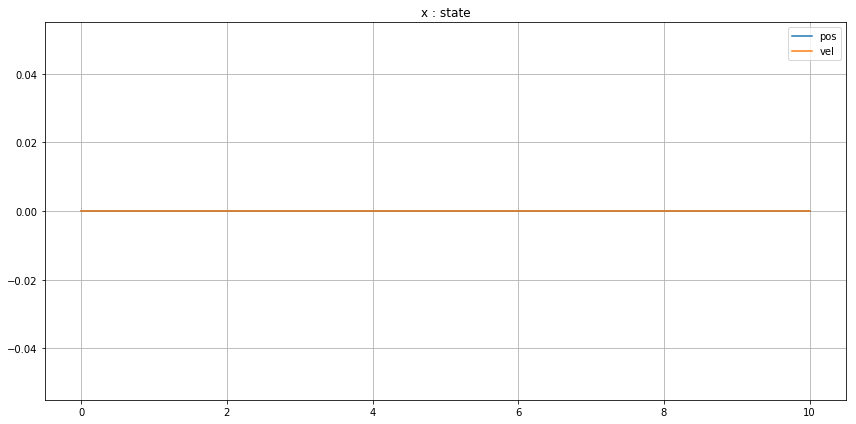

In [35]:
N = int((len(res.x) - 1)/3 - 1)
t_f = res.x[0]
t_list = np.linspace(0, t_f, N+1)
u_list = np.array(res.x[1:N+2]).reshape((N+1, 1))
x_list = np.array(res.x[N+2:]).reshape((N+1, 2))
print(u_list)

fig_size = 6
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(fig_size*2, fig_size))
ax.plot(t_list, x_list[:,0], label="pos")
ax.plot(t_list, x_list[:,1], label="vel")
#ax.set_ylim(-1, 10)
ax.grid()
ax.legend()
ax.set_title('x : state')

fig.tight_layout()
plt.show()